# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.  

<u>**Описание тарифов**</u>

***Тариф «Смарт»***

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

***Тариф «Ультра»***

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

>«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

>В данных есть звонки с нулевой продолжительностью. Нулями обозначены пропущенные звонки.

## Общая информация

Загрузим файлы с данными и ознакомимся с ними.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from scipy import stats as st

In [2]:
# загрузим фалы с данными и ознакомимся с ними

try:
    users = pd.read_csv('/datasets/users.csv')
    calls = pd.read_csv('/datasets/calls.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    internet = pd.read_csv('/datasets/internet.csv', index_col=0)
    tariffs = pd.read_csv('/datasets/tariffs.csv')
except:
    users = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Статистический_анализ_данных/users.csv')
    messages = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Статистический_анализ_данных/messages.csv')
    internet = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Статистический_анализ_данных/internet.csv', index_col=0)
    tariffs = pd.read_csv('/Users/alex/Desktop/Яндекс_Практикум/Проекты/Статистический_анализ_данных/tariffs.csv')
    
users.info()
calls.info()
messages.info()
internet.info()
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.D

In [3]:
# посмотрим на данные в таблицах
display(users.sample(3))
display(calls.sample(3))
display(messages.sample(3))
display(internet.sample(3))
tariffs

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
54,1054,33,NaN,Омск,Кристина,Платонова,2018-03-20,smart
175,1175,22,NaN,Москва,Юлий,Марков,2018-04-08,smart
144,1144,65,NaN,Улан-Удэ,Ефим,Ефремов,2018-04-29,smart


,id,call_date,duration,user_id
79217,1197_209,2018-08-17,12.14,1197
198062,1484_219,2018-10-08,14.10,1484
133003,1341_233,2018-11-12,8.64,1341


,id,message_date,user_id
20956,1089_959,2018-12-11,1089
97695,1401_27,2018-05-27,1401
118143,1480_75,2018-03-20,1480


,id,mb_used,session_date,user_id
15290,1054_270,201.35,2018-07-04,1054
59430,1200_260,564.22,2018-06-15,1200
35788,1124_168,937.99,2018-11-08,1124


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


***Описание данных***

Таблица `users` (информация о пользователях):
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

Таблица `calls` (информация о звонках):
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Предобработка данных

### Тип данных

Приведём данные к нужным типам.

In [4]:
# в таблице users, дату приведём к типу datatime
# данные в стобце с идентификатором пользователя приведём к строковому типу
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")
users['user_id'] = users['user_id'].astype('str')
users.info()
users.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    object        
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
172,1172,40,NaT,Санкт-Петербург,Алан,Карасев,2018-05-05,smart


In [5]:
# в таблице calls дату приведём к datatime
# длительность звонков округлим в сторону увеличения и приведём к целочисленному типу
# данные в стобце с идентификатором пользователя приведём к строковому типу
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')
calls['user_id'] = calls['user_id'].astype('str')
calls.info()
calls.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
94556,1240_84,2018-11-08,14,1240


In [6]:
# в таблице message дату приведём к datatime
# длительность звонков округлим в сторону увеличения и приведём к целочисленному типу
# данные в стобце с идентификатором пользователя приведём к строковому типу
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")
messages['user_id'] = messages['user_id'].astype('str')
messages.info()
messages.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
59526,1262_17,2018-11-13,1262


In [7]:
# в таблице internet дату приведём к datatime
# интернет-сессии округлим в сторону увеличения и приведём к целочисленному типу
# данные в стобце с идентификатором пользователя приведём к строковому типу
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")
internet['user_id'] = internet['user_id'].astype('str')
internet.info()
internet.sample()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
95855,1324_49,619.8,2018-12-02,1324


In [10]:
# переименуем столбец в таблице с тарифами для удосбтва дальнейших расчётов
tariffs.rename(columns = {'tariff_name' : 'tariff'}, inplace = True)
tariffs.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff'],
      dtype='object')

Во всех таблицах дату привели к специальному типу `datatime`, идетификаторы пользователей к строковому типу, округлили минуты, переименовали столбец в таблице `tariffs` для дальнейшего удобства.

### Подготовка данных

In [11]:
# добавим столбец с месяцем в таблицы звонков, сообщений, интернет-трафика
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Создадим новую базу данных, в неё поместим данные с `user_id`, месяцем, количеством звонков, продолжительностью звонков, количеством смс, количеством мегабайт интернет-трафика, город и название тарифа.

In [12]:
# сгруппируем таблицы звонков, сообщений, интернета, почитаем количество и сумму трафика, добавим в новый датафрейм
# присоединим столбцы с данными города и тарифа из таблицы с пользователями
# переименуем столбцы в более понятные наименования
df = pd.concat([calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']),
                messages.groupby(['user_id', 'month'])['id'].count(),
                internet.groupby(['user_id', 'month']).sum()['mb_used']], axis=1).reset_index()

df = df.merge(users[['user_id', 'city', 'tariff']], on='user_id', how='outer')
df = df.merge(tariffs, on='tariff', how='outer')
df.columns = ['user_id', 'month', 'calls_pcs', 'calls_minutes', 'sms_pcs', 'internet_mb', 'city', 'tariff',
              'mess_inc', 'mb_inc', 'min_inc', 'rub_fee', 'rub_gb', 'rub_mes', 'rub_min']
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        3216 non-null   object 
 1   month          3214 non-null   float64
 2   calls_pcs      3174 non-null   float64
 3   calls_minutes  3174 non-null   float64
 4   sms_pcs        2717 non-null   float64
 5   internet_mb    3203 non-null   float64
 6   city           3216 non-null   object 
 7   tariff         3216 non-null   object 
 8   mess_inc       3216 non-null   int64  
 9   mb_inc         3216 non-null   int64  
 10  min_inc        3216 non-null   int64  
 11  rub_fee        3216 non-null   int64  
 12  rub_gb         3216 non-null   int64  
 13  rub_mes        3216 non-null   int64  
 14  rub_min        3216 non-null   int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 402.0+ KB


,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,mess_inc,mb_inc,min_inc,rub_fee,rub_gb,rub_mes,rub_min
738,1381,2.0,98.0,762.0,44.0,27738.28,Москва,ultra,1000,30720,3000,1950,150,1,1
2669,1378,10.0,70.0,453.0,9.0,13834.81,Иркутск,smart,50,15360,500,550,200,3,3
1837,1183,7.0,40.0,326.0,24.0,9883.50,Владивосток,smart,50,15360,500,550,200,3,3
136,1085,12.0,19.0,100.0,NaN,15374.60,Омск,ultra,1000,30720,3000,1950,150,1,1
739,1381,3.0,107.0,866.0,41.0,25040.16,Москва,ultra,1000,30720,3000,1950,150,1,1


Посчитаем помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

In [13]:
# создадим функцию для подсчёта выручки
# добавим в таблицу столбец с выручкой
# добавляем только положительные числа после подсчёта, т.к. отрицательные значения - это неиспользованный трафик в рамках тарифа
def monthly_revenue(row):
    sms_price = (row['mess_inc'] - row['sms_pcs']) * row['rub_mes']
    minut_price = (row['calls_minutes'] - row['min_inc']) * row['rub_min']
    mb_price =  np.floor((row['internet_mb'] - row['mb_inc']) * row['rub_gb'] / 1024)
    total = 0
    for i in [sms_price, minut_price, mb_price]:
        if i > 0:
            total += i 
    return total + row['rub_fee']

df['monthly_revenue'] = df.apply(monthly_revenue, axis=1)    
df.sample(5)

,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,mess_inc,mb_inc,min_inc,rub_fee,rub_gb,rub_mes,rub_min,monthly_revenue
2612,1370,4.0,24.0,159.0,NaN,13011.53,Новороссийск,smart,50,15360,500,550,200,3,3,550.0
822,1405,12.0,41.0,244.0,53.0,25004.15,Набережные Челны,ultra,1000,30720,3000,1950,150,1,1,2897.0
343,1200,8.0,92.0,627.0,49.0,16303.33,Санкт-Петербург,ultra,1000,30720,3000,1950,150,1,1,2901.0
2556,1353,5.0,51.0,374.0,53.0,19683.57,Санкт-Петербург,smart,50,15360,500,550,200,3,3,1394.0
3171,1490,4.0,38.0,270.0,38.0,13669.58,Москва,smart,50,15360,500,550,200,3,3,586.0


In [14]:
# посмотрим на пропущенные значения
# удалим две строки, где есть только данные с городом и тарифом, они не несут полезной информации
display(df[df['month'].isna() == True])
df = df.dropna(subset=['month'])

,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,mess_inc,mb_inc,min_inc,rub_fee,rub_gb,rub_mes,rub_min,monthly_revenue
985,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra,1000,30720,3000,1950,150,1,1,1950.0
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart,50,15360,500,550,200,3,3,550.0


In [15]:
# удалим из таблицы нужно только для подсчётов данные
df = df.drop(['mess_inc', 'mb_inc', 'min_inc', 'rub_fee', 'rub_gb', 'rub_mes', 'rub_min'], axis=1,)
df.sample(5)

,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,monthly_revenue
2014,1219,8.0,76.0,508.0,6.0,21655.34,Киров,smart,1935.0
1028,1009,3.0,13.0,109.0,2.0,7350.15,Пермь,smart,694.0
3188,1494,9.0,66.0,501.0,NaN,16962.51,Омск,smart,865.0
430,1254,1.0,59.0,466.0,NaN,19685.01,Москва,ultra,1950.0
2886,1428,8.0,11.0,66.0,NaN,7039.10,Новосибирск,smart,550.0


In [16]:
# заполним пропущенные значения нулями в столбцах с минутами, звонками и интернет-траффиком
# числовые значения теперь можно заменить на целочисленные
df['calls_pcs'] = df['calls_pcs'].fillna(0)
df['calls_minutes'] = df['calls_minutes'].fillna(0)
df['sms_pcs'] = df['sms_pcs'].fillna(0)
df['internet_mb'] = df['internet_mb'].fillna(0)

df['month'] = df['month'].astype('str')
df['calls_pcs'] = df['calls_pcs'].astype('int')
df['calls_minutes'] = df['calls_minutes'].astype('int')
df['sms_pcs'] = df['sms_pcs'].astype('int')
df['internet_mb'] = df['internet_mb'].astype('int')
df['monthly_revenue'] = df['monthly_revenue'].astype('int')
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3214
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          3214 non-null   object
 1   month            3214 non-null   object
 2   calls_pcs        3214 non-null   int64 
 3   calls_minutes    3214 non-null   int64 
 4   sms_pcs          3214 non-null   int64 
 5   internet_mb      3214 non-null   int64 
 6   city             3214 non-null   object
 7   tariff           3214 non-null   object
 8   monthly_revenue  3214 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 251.1+ KB


user_id            0
month              0
calls_pcs          0
calls_minutes      0
sms_pcs            0
internet_mb        0
city               0
tariff             0
monthly_revenue    0
dtype: int64

Посчитали для каждого пользователя:  
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.  

Посчитали помесячную выручку с каждого пользователя (вычли бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножили на значение из тарифного плана; прибавили абонентскую плату, соответствующую тарифному плану).

## Анализ данных

Рассмотрим поведение клиентов оператора, исходя из выборки.

In [17]:
# отсортируем базу данных по тарифам в две новые базы данных
df_smart = df.where(df['tariff'] == 'smart')
df_ultra = df.where(df['tariff'] == 'ultra')
display(df_smart.sample())
display(df_ultra.sample())
df_smart.info()
df_ultra.info()

,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,monthly_revenue
1703,1157,8.0,70.0,450.0,0.0,18428.0,Москва,smart,1149.0


,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,monthly_revenue
2771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3214
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          2229 non-null   object 
 1   month            2229 non-null   object 
 2   calls_pcs        2229 non-null   float64
 3   calls_minutes    2229 non-null   float64
 4   sms_pcs          2229 non-null   float64
 5   internet_mb      2229 non-null   float64
 6   city             2229 non-null   object 
 7   tariff           2229 non-null   object 
 8   monthly_revenue  2229 non-null   float64
dtypes: float64(5), object(4)
memory usage: 251.1+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3214
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          985 non-null    object 
 1   month            985 non-null    object 
 2   calls_pcs        985 non-null    float6

In [18]:
# описательные статистики
display(df_smart.describe())
display(df_ultra.describe())
df.describe()

,calls_pcs,calls_minutes,sms_pcs,internet_mb,monthly_revenue
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,58.463437,417.934948,33.384029,16207.879318,1259.344549
std,25.939858,190.313730,28.227876,5870.480175,778.152371
min,0.000000,0.000000,0.000000,0.000000,550.000000
25%,40.000000,282.000000,10.000000,12643.000000,652.000000
50%,60.000000,422.000000,28.000000,16506.000000,979.000000
75%,76.000000,545.000000,51.000000,20042.000000,1670.000000
max,198.000000,1435.000000,143.000000,38552.000000,6600.000000


,calls_pcs,calls_minutes,sms_pcs,internet_mb,monthly_revenue
count,985.000000,985.000000,985.000000,985.000000,985.000000
mean,73.392893,526.623350,49.363452,19468.322843,2817.543147
std,43.916853,317.606098,47.804457,10087.173788,480.072410
min,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,41.000000,284.000000,6.000000,11770.000000,2824.000000
50%,74.000000,518.000000,38.000000,19308.000000,2895.000000
75%,104.000000,752.000000,79.000000,26837.000000,2931.000000
max,244.000000,1673.000000,224.000000,49745.000000,5615.000000


,calls_pcs,calls_minutes,sms_pcs,internet_mb,monthly_revenue
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,451.244866,38.281269,17207.112943,1736.888301
std,33.236368,241.909978,36.148326,7570.964206,1003.340171
min,0.000000,0.000000,0.000000,0.000000,550.000000
25%,40.000000,282.000000,9.000000,12491.250000,709.250000
50%,62.000000,443.000000,30.000000,16942.500000,1593.000000
75%,82.000000,589.000000,57.000000,21424.000000,2847.000000
max,244.000000,1673.000000,224.000000,49745.000000,6600.000000


,calls_pcs,calls_minutes,sms_pcs,internet_mb,monthly_revenue
calls_pcs,1.000000,0.980975,0.177385,0.286441,0.330634
calls_minutes,0.980975,1.000000,0.172391,0.280415,0.333907
sms_pcs,0.177385,0.172391,1.000000,0.195721,0.231841
internet_mb,0.286441,0.280415,0.195721,1.000000,0.567825
monthly_revenue,0.330634,0.333907,0.231841,0.567825,1.000000


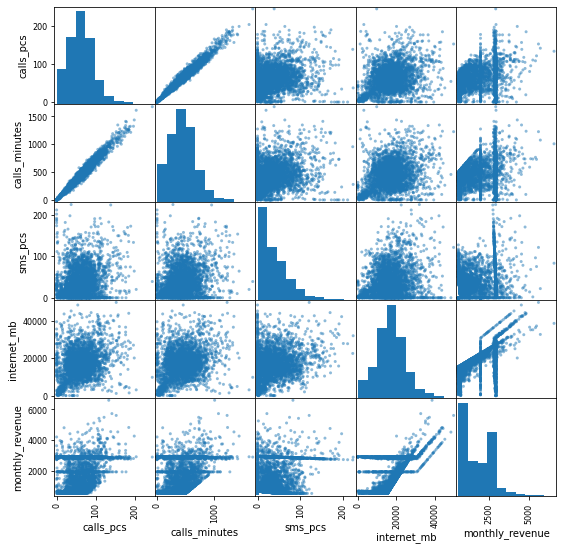

In [19]:
# диаграмма рассеяния и коэффициент корреляции
pd.plotting.scatter_matrix(df, figsize=(9, 9))
df.corr()

Хорошо видны зависимости увеличения расходов на связь, при увеличении интернет-трафика и количества минут, это значит, что пользователи выходят за лимиты тарифных планов. Заметны растущие распределения по месяцам. И прослеживается разница в зависимостях от использования двух разных тарифах, при использовании интернета, смс и звонков.

In [20]:
# дисперсия
display(df.var())
display(df_smart.var())
df_ultra.var()

calls_pcs          1.104656e+03
calls_minutes      5.852044e+04
sms_pcs            1.306701e+03
internet_mb        5.731950e+07
monthly_revenue    1.006691e+06
dtype: float64

calls_pcs          6.728762e+02
calls_minutes      3.621932e+04
sms_pcs            7.968130e+02
internet_mb        3.446254e+07
monthly_revenue    6.055211e+05
dtype: float64

calls_pcs          1.928690e+03
calls_minutes      1.008736e+05
sms_pcs            2.285266e+03
internet_mb        1.017511e+08
monthly_revenue    2.304695e+05
dtype: float64

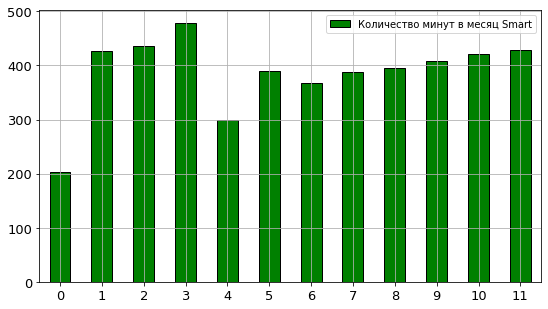

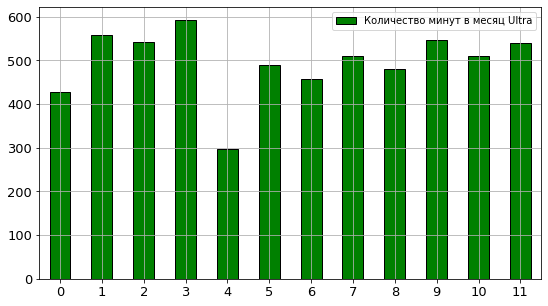

In [21]:
# минуты в месяц по разным тарифам
df_smart.pivot_table(index = 'month',
                     values = 'calls_minutes',
                     aggfunc = 'mean').reset_index().sort_values(by='month').plot(kind = 'bar',
                                            grid=True, color = 'g', ec='black', fontsize=13, figsize=(9,5))
plt.legend(['Количество минут в месяц Smart'], loc = 1)
plt.xticks(rotation=0)
plt.show()

df_ultra.pivot_table(index = 'month',
                     values = 'calls_minutes',
                     aggfunc = 'mean').reset_index().sort_values(by='month').plot(kind = 'bar',
                                            grid=True, color = 'g', ec='black', fontsize=13, figsize=(9,5))
plt.legend(['Количество минут в месяц Ultra'], loc = 1)
plt.xticks(rotation=0)
plt.show()

Несмотря на лимиты тарифных планов, пользователи тратят примерно одинаковое количество минут: на Ultra больше, в среднем, на 110 минут.
Что-то произошло в 4-м месяце, возможно, были сбои в сети оператора, потрачено всего 300 минут у обеих групп.  
В остальном распределение равномерное, даже совпадает по месяцам.

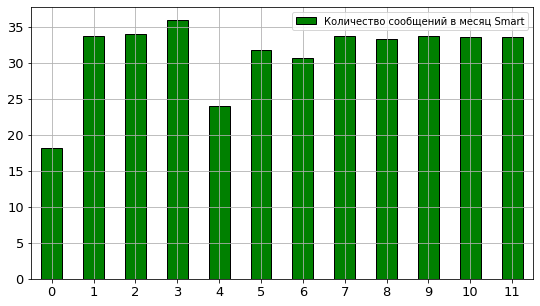

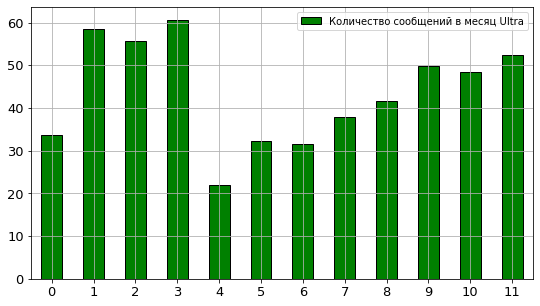

In [22]:
# сообщений в месяц по разным тарифам
df_smart.pivot_table(index = 'month',
                     values = 'sms_pcs',
                     aggfunc = 'mean').reset_index().sort_values(by='month').plot(kind = 'bar',
                                            grid=True, color = 'g', ec='black', fontsize=13, figsize=(9,5))
plt.legend(['Количество сообщений в месяц Smart'], loc = 1)
plt.xticks(rotation=0)
plt.show()

df_ultra.pivot_table(index = 'month',
                     values = 'sms_pcs',
                     aggfunc = 'mean').reset_index().sort_values(by='month').plot(kind = 'bar',
                                            grid=True, color = 'g', ec='black', fontsize=13, figsize=(9,5))
plt.legend(['Количество сообщений в месяц Ultra'], loc = 1)
plt.xticks(rotation=0)
plt.show()

Абоненты вообще не выходят за границы тарифного лимита, максимальное количество отправленных сообщений: `224`, что в 4,5 раза меньше лимита тарифа Ultra. В среднем же по всей базе тратится не более `39` сообщений в месяц. Сообщения не пользуются популярностью.

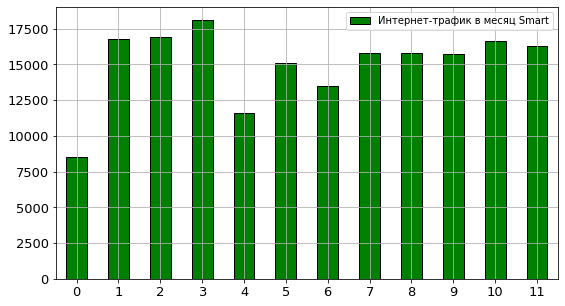

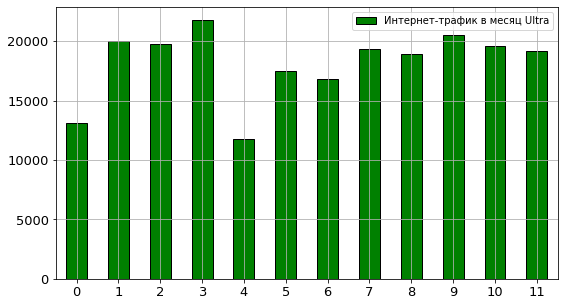

In [23]:
# интернет-трафик в месяц по разным тарифам
df_smart.pivot_table(index = 'month',
                     values = 'internet_mb',
                     aggfunc = 'mean').reset_index().sort_values(by='month').plot(kind = 'bar',
                                            grid=True, color = 'g', ec='black', fontsize=13, figsize=(9,5))
plt.legend(['Интернет-трафик в месяц Smart'], loc = 1)
plt.xticks(rotation=0)
plt.show()

df_ultra.pivot_table(index = 'month',
                     values = 'internet_mb',
                     aggfunc = 'mean').reset_index().sort_values(by='month').plot(kind = 'bar',
                                            grid=True, color = 'g', ec='black', fontsize=13, figsize=(9,5))
plt.legend(['Интернет-трафик в месяц Ultra'], loc = 1)
plt.xticks(rotation=0)
plt.show()

Больше половины пользователей превышают лимит интернета тарифного плана Smart, в среднем используя более `16gb` интернет-трафика. В Ultra большинство не выходит за лимиты, в среднем не более `20gb`.

Построим гистрограммы распределений расхода пользователями звонков, сообщений и интернет-трафика по тарифам.

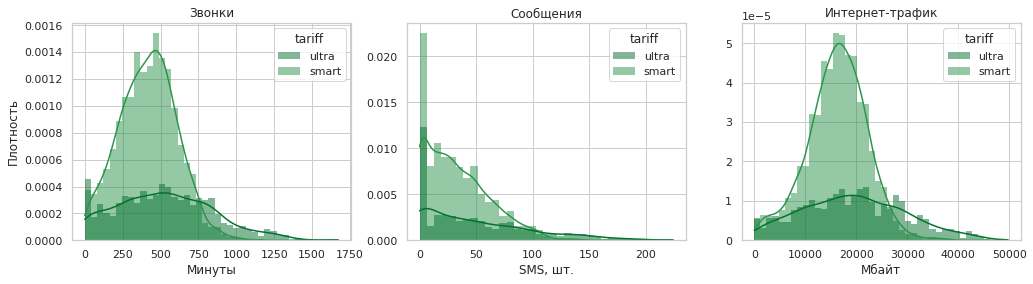

In [24]:
#гистограммы:
sns.set_theme(style="whitegrid", palette="Greens_r")
fig,axes=plt.subplots(1,3)
fig.set_size_inches(17, 4)
ax = sns.histplot(df, x='calls_minutes', hue='tariff', kde=True, stat='density', linewidth=0,  ax = axes[0])
ax1 = sns.histplot(df, x='sms_pcs', hue='tariff', kde=True, stat='density', linewidth=0, ax = axes[1])
ax2 = sns.histplot(df, x='internet_mb', hue='tariff', kde=True, stat='density', linewidth=0, ax = axes[2])

ax.set(title = 'Звонки',
      xlabel = 'Минуты',
      ylabel = 'Плотность')
ax1.set(title = 'Сообщения',
      xlabel = 'SMS, шт.',
      ylabel = '')
ax2.set(title = 'Интернет-трафик',
      xlabel = 'Мбайт',
      ylabel = '')
     
plt.show()

Распределения по тарифам близки к нормальным. Тариф `Ultra` смещён вправо относительно тарифа `Smart`, что логично, исходя из количества предоставляемых лимитов тарифных планов. Распределение количества сообщений близко к геометрическому распределению, sms в современном мире используются крайне редко.

## Проверка гипотез

### Проверим гипотезы по тарифам:

* H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
* H1: выручка пользователей тарифов «Ультра» и «Смарт» различается
* Пороговое значение `alpha`: `0.05`

Т.к. выборки у нас независимые и количество данных в них больше 50, используем t-критерий Стьюдента. К тому же в обеих измерена одна и та же переменная — нет оснований полагать, что разброс будет сильно отличаться.

In [25]:
# посчитаем стандартное отклонение, среднее, медиану и границы интервалов для месячной выручки тарифа Smart
std_smart = np.std(df_smart['monthly_revenue'])
range_limit_smart_1 = df_smart['monthly_revenue'].mean() - 3*std_smart
range_limit_smart_2 = df_smart['monthly_revenue'].mean() + 3*std_smart
display(range_limit_smart_1, range_limit_smart_2)
df_smart['monthly_revenue'].mean(), df_smart['monthly_revenue'].median()

-1074.5888483495041

3593.2779465998406

(1259.3445491251682, 979.0)

Выборка скошена вправо, медиана меньше среднего.

In [26]:
# посчитаем стандартное отклонение, среднее, медиану и границы интервалов для месячной выручки тарифа Ultra
std_ultra = np.std(df_ultra['monthly_revenue'])
range_limit_ultra_1 = df_ultra['monthly_revenue'].mean() - 3*std_ultra
range_limit_ultra_2 = df_ultra['monthly_revenue'].mean() + 3*std_ultra
display(range_limit_ultra_1, range_limit_ultra_2)
df_ultra['monthly_revenue'].mean(), df_ultra['monthly_revenue'].median()

1378.0571779885913

4257.029116427652

(2817.543147208122, 2895.0)

Выборка немного скошена влево, медиана больше среднего.

In [27]:
# ограничим выборки по правилу 3-х сигм

df_smart_mean = df_smart['monthly_revenue'][(df_smart['monthly_revenue'] <= range_limit_smart_2)]
df_ultra_mean = df_ultra['monthly_revenue'][(df_ultra['monthly_revenue'
                                                     ] <= range_limit_ultra_2)&(df_ultra['monthly_revenue'
                                                                                        ] >= range_limit_ultra_1)]

alpha = .05
                
results = st.ttest_ind(df_smart_mean, df_ultra_mean)
                          
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Выручка пользователей тарифов «Ультра» и «Смарт» различается

### Проверим гипотезы по городам:

* H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
* H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
* Пороговое значение alpha: 0.05

Т.к. выборки у нас независимые и количество данных в них больше 50, используем t-критерий Стьюдента. К тому же в обеих измерена одна и та же переменная — нет оснований полагать, что разброс будет сильно отличаться.

In [28]:
# посмотрим на все возможные города
df['city'].unique()

array(['Краснодар', 'Москва', 'Новокузнецк', 'Иваново', 'Омск', 'Уфа',
       'Томск', 'Санкт-Петербург', 'Тверь', 'Ярославль', 'Тюмень',
       'Ростов-на-Дону', 'Калуга', 'Тула', 'Волгоград', 'Саранск',
       'Иркутск', 'Череповец', 'Набережные Челны', 'Новосибирск',
       'Брянск', 'Тольятти', 'Нижний Тагил', 'Воронеж', 'Махачкала',
       'Пермь', 'Сургут', 'Пенза', 'Мурманск', 'Самара',
       'Нижний Новгород', 'Кемерово', 'Кострома', 'Оренбург', 'Чебоксары',
       'Магнитогорск', 'Астрахань', 'Нижневартовск', 'Челябинск',
       'Курган', 'Красноярск', 'Владивосток', 'Смоленск', 'Владимир',
       'Казань', 'Саратов', 'Севастополь', 'Рязань', 'Екатеринбург',
       'Стерлитамак', 'Ульяновск', 'Балашиха', 'Барнаул', 'Киров', 'Сочи',
       'Вологда', 'Чита', 'Петрозаводск', 'Хабаровск', 'Ставрополь',
       'Улан-Удэ', 'Курск', 'Якутск', 'Химки', 'Владикавказ', 'Ижевск',
       'Орёл', 'Белгород', 'Архангельск', 'Липецк', 'Волжский', 'Тамбов',
       'Калининград', 'Новороссий

In [29]:
# создадим датасеты с регионами и Москвой
df_moscow = df.where(df['city'] == 'Москва')
df_regions = df.where(df['city'] != 'Москва')
display(df_moscow.sample())
df_regions.sample()

,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,monthly_revenue
2402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,user_id,month,calls_pcs,calls_minutes,sms_pcs,internet_mb,city,tariff,monthly_revenue
2637,1373,7.0,2.0,11.0,50.0,21507.0,Улан-Удэ,smart,1750.0


In [30]:
# посчитаем стандартное отклонение, среднее, медиану и границы интервалов для месячной выручки в Москве
std_moscow = np.std(df_moscow['monthly_revenue'])
range_limit_moscow_1 = df_moscow['monthly_revenue'].mean() - 3*std_moscow
range_limit_moscow_2 = df_moscow['monthly_revenue'].mean() + 3*std_moscow
display(range_limit_moscow_1, range_limit_moscow_2)
df_moscow['monthly_revenue'].mean(), df_moscow['monthly_revenue'].median()

-1245.717797108031

4901.842183360077

(1828.062193126023, 1708.0)

Выборка немного скошена вправо, медиана меньше среднего.

In [31]:
# посчитаем стандартное отклонение, среднее, медиану и границы интервалов для месячной выручки в регионах
std_regions = np.std(df_regions['monthly_revenue'])
range_limit_regions_1 = df_regions['monthly_revenue'].mean() - 3*std_regions
range_limit_regions_2 = df_regions['monthly_revenue'].mean() + 3*std_regions
display(range_limit_regions_1, range_limit_regions_2)
df_regions['monthly_revenue'].mean(), df_regions['monthly_revenue'].median()

-1275.1663499470096

4706.1406104156995

(1715.487130234345, 1548.0)

Выборка немного скошена вправо, медиана меньше среднего.

In [32]:
# ограничим выборки по правилу 3-х сигм

df_moscow_mean = df_moscow['monthly_revenue'][(df_moscow['monthly_revenue'] <= range_limit_moscow_2)]
df_regions_mean = df_regions['monthly_revenue'][(df_regions['monthly_revenue'] <= range_limit_regions_2)]

alpha = .05
                
results = st.ttest_ind(df_moscow_mean, df_regions_mean)
                          
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.006668282235906335
Отвергаем нулевую гипотезу


Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

## Общий вывод

Тарифные планы хорошо сбалансированы, но можно предложить некоторые рекомендации: например, расширить линейку тарифных планов.  

Больше половины пользователей превышают лимит интернета тарифного плана "Смарт", в среднем используя более `16gb` .  
Пользователи "Ультра", в основном, не выходят за лимиты, в среднем не более `20gb` .  
Сообщения непопулярны, тарифные лимиты не тратятся. В среднем, по всей базе, пользователи отправляют не более `39` сообщений в месяц.
Несмотря на лимиты тарифных планов, пользователи тратят примерно одинаковое количество минут: на "Ультра" больше, чем на "Смарте" в среднем, на `110` минут.

Пользователь тарифа "Смарт", в среднем, тратит в "Мегалайне" `1262` рубля (`69%` пользователей, `50%` выручки).
Пользователь тарифа "Ультра", в среднем, тратит в "Мегалайне" `2818` рублей (`31%` пользователей, `50%` выручки).
Житель Москвы, в среднем, тратит в "Мегалайне" `1830` рублей (`19%` пользователей, `20%` выручки).
Житель региона, в среднем, тратит в "Мегалайне" `1718` рублей (`81%` пользователей, `80%` выручки).  

Можно предложить создать новый тарифный план, дополняющий существующие:
* Ежемесячная плата: 950 рублей
* Включено 600 минут разговора, 50 сообщений и 20 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:
* минута разговора: 1.5 рубля
* сообщение: 5 рублей
* 1 Гб интернет-трафика: 160 рублей